In [48]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

In [16]:
import os
from datetime import datetime
from typing import List, Tuple

import numpy as np
import pandas as pd
import tensorflow as tf
from keras.callbacks import TensorBoard
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow import keras

from tensorflow.keras import layers


X_train shape:  (5791,)
X_val shape:  (1931,)
X_test shape:  (1931,)


/Users/henrystoll/SDK/anaconda3/envs/tensorflow/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


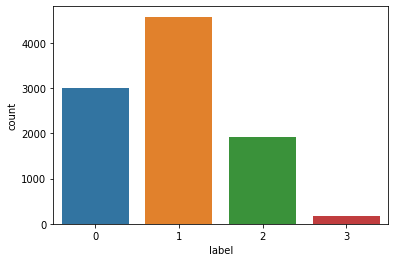

In [26]:
df = pd.read_csv('../data/tweets_50.csv')
X = df['text_tokenized']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)  # 0.8 * 0.25 = 0.2

class_names = y.unique().tolist()
# print("Class names: ", class_names)
print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)
# TODO: save
sns.countplot(y, order=[0, 1, 2, 3]);

In [28]:
HP = {
    'batch_size': 128,
    'max_tokens':40_000,
    'output_sequence_length': 400,
}

def make_vectorizer(max_tokens: int, output_sequence_length: int) -> TextVectorization:
    vect = TextVectorization(max_tokens=max_tokens, output_sequence_length=output_sequence_length)
    text_ds = tf.data.Dataset.from_tensor_slices(X_train.values).batch(HP.batch_size)
    vect.adapt(text_ds)
    return vect


def get_embedding_matrix(embedding_dim, num_tokens, word_index):
    path_to_glove_file = os.path.join(
        os.path.expanduser("~"), f"Documents/Datasets/glove.6B.{embedding_dim}d.txt"
    )
    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs
    print("Found {} word vectors.".format(len(embeddings_index)))
    hits = 0
    misses = 0
    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))
    return embedding_matrix

def make_embedding_layer(voc: List[str] , embedding_dim:int) -> layers.Embedding:
    word_index = dict(zip(voc, range(len(voc))))
    num_tokens = len(voc) + 2

    # just testing if word_index works
    test = ["the", "cat", "sat", "on", "the", "mat"]
    print("word_index test:")
    print(test, " --> ", [word_index[w] for w in test])

    embedding_matrix = get_embedding_matrix(embedding_dim, num_tokens, word_index)

    return layers.Embedding(
        num_tokens,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
    )

vectorizer = make_vectorizer(max_tokens=HP.max_tokens,
                             output_sequence_length=HP.output_sequence_length)
vocabulary = vectorizer.get_vocabulary()
embedding_layer = make_embedding_layer(vocabulary, embedding_dim=100)


word_index test:
['the', 'cat', 'sat', 'on', 'the', 'mat']  -->  [4, 1170, 2063, 17, 4, 8835]


In [54]:
def make_model():
    string_input = keras.Input(shape=(1,), dtype="string")
    x = vectorizer(string_input)
    # int_sequences_input = keras.Input(shape=(None,), dtype="int64")(x)
    # embedded_sequences = embedding_layer(int_sequences_input)
    x = embedding_layer(x)
    x = layers.Conv1D(filters=128, kernel_size=5, activation="relu")(x)
    x = layers.MaxPooling1D(pool_size=5)(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    output_ = layers.Dense(len(class_names), activation="softmax")(x)
    model = keras.Model(string_input, output_)
    model.summary()

    model.compile(
        loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
    )
    return model


def get_model_name() -> Tuple[str, str]:
    model_name = ""
    ts = datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir = "logs/" + model_name + '_' + ts
    return model_name, log_dir


model_name, log_dir = get_model_name()


model = make_model()

keras.utils.plot_model(model, f"img/{model_name}.png", show_shapes=True)


tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_acc',
    verbose=1,
    patience=10,
    restore_best_weights=True)

# class_weight = {0: 1., 1: 1., 2: 1., 3: 1} # TODO: use?

history = model.fit(X_train, y_train,
                    batch_size=HP.batch_size,
                    epochs=200,
                    validation_data=(X_val, y_val),
                    # class_weight=class_weight,
                    callbacks=[tensorboard, early_stopping])



Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_4 (TextVe (None, 400)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 400, 200)          8000400   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 396, 128)          128128    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 79, 128)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 75, 128)           82048     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 15, 128)           0   